In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader_pw import *
from cnn_model_1 import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'pairwise_lstm.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = PWDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

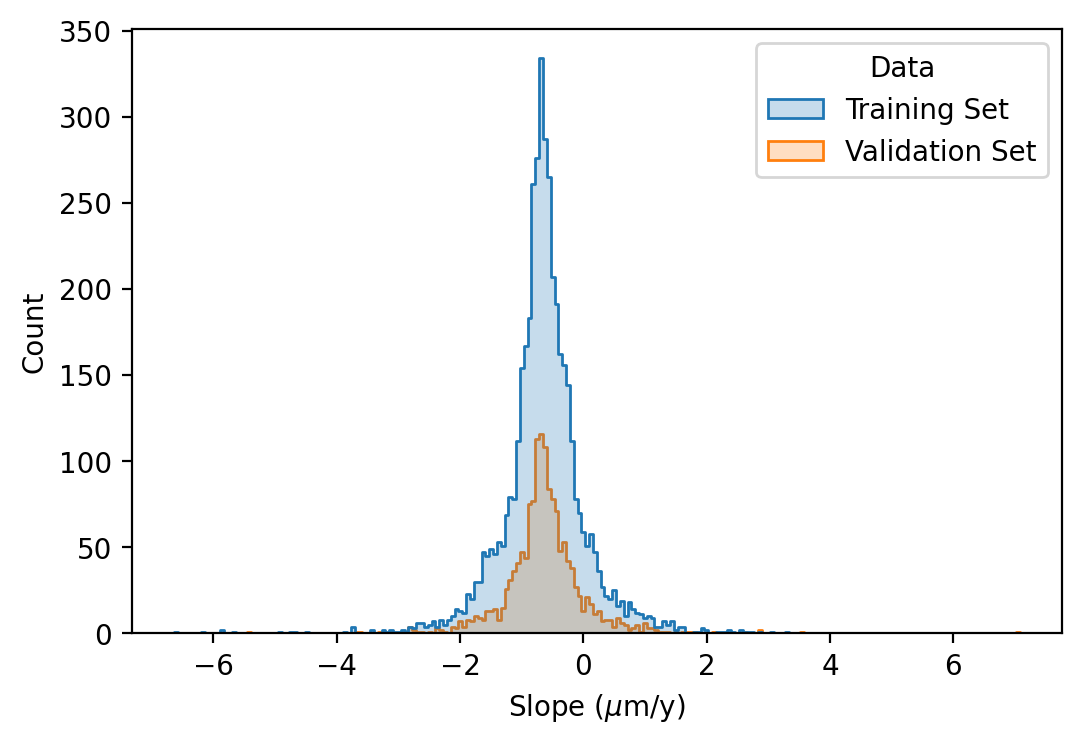

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

4445 1482


In [6]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1
print(ts)

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

2


In [7]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        torch.save(model.state_dict(),'pw_statedict.pt')
        #best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 70/70 [00:09<00:00,  7.29it/s, batch_loss=1.81, running_loss=34.5]


Train Loss: 34.4622 | Valid Loss: inf ===========> 10.8139 | Test Loss: 10.1171 | Saving model...


Epoch [2/200]: 100%|██████████| 70/70 [00:09<00:00,  7.26it/s, batch_loss=0.605, running_loss=32.6]


Train Loss: 32.6402 | Valid Loss: 10.8139 ===========> 10.6277 | Test Loss: 9.6015 | Saving model...


Epoch [3/200]: 100%|██████████| 70/70 [00:09<00:00,  7.49it/s, batch_loss=0.518, running_loss=32]


Train Loss: 31.9580 | Valid Loss: 10.6277 ===========> 10.3624 | Test Loss: 9.8297 | Saving model...


Epoch [4/200]: 100%|██████████| 70/70 [00:09<00:00,  7.32it/s, batch_loss=0.29, running_loss=30.8]


Train Loss: 30.8369 | Valid Loss: 10.4990


Epoch [5/200]: 100%|██████████| 70/70 [00:09<00:00,  7.36it/s, batch_loss=0.447, running_loss=30]


Train Loss: 30.0484 | Valid Loss: 10.3624 ===========> 8.9763 | Test Loss: 8.4406 | Saving model...


Epoch [6/200]: 100%|██████████| 70/70 [00:09<00:00,  7.43it/s, batch_loss=0.424, running_loss=28.3]


Train Loss: 28.3059 | Valid Loss: 8.9763 ===========> 8.3232 | Test Loss: 8.1409 | Saving model...


Epoch [7/200]: 100%|██████████| 70/70 [00:09<00:00,  7.48it/s, batch_loss=0.524, running_loss=26.8]


Train Loss: 26.8239 | Valid Loss: 8.3232 ===========> 7.9594 | Test Loss: 8.1788 | Saving model...


Epoch [8/200]: 100%|██████████| 70/70 [00:09<00:00,  7.38it/s, batch_loss=0.242, running_loss=24.7]


Train Loss: 24.6982 | Valid Loss: 7.9594 ===========> 7.7226 | Test Loss: 8.0287 | Saving model...


Epoch [9/200]: 100%|██████████| 70/70 [00:09<00:00,  7.46it/s, batch_loss=0.338, running_loss=24.1]


Train Loss: 24.1321 | Valid Loss: 7.7226 ===========> 7.5202 | Test Loss: 7.9087 | Saving model...


Epoch [10/200]: 100%|██████████| 70/70 [00:09<00:00,  7.34it/s, batch_loss=0.362, running_loss=22.8]


Train Loss: 22.8448 | Valid Loss: 7.5202 ===========> 6.9943 | Test Loss: 7.1349 | Saving model...


Epoch [11/200]: 100%|██████████| 70/70 [00:09<00:00,  7.43it/s, batch_loss=0.219, running_loss=20.9]


Train Loss: 20.9486 | Valid Loss: 7.7044


Epoch [12/200]: 100%|██████████| 70/70 [00:09<00:00,  7.40it/s, batch_loss=0.159, running_loss=20.3]


Train Loss: 20.3460 | Valid Loss: 7.2685


Epoch [13/200]: 100%|██████████| 70/70 [00:09<00:00,  7.42it/s, batch_loss=0.143, running_loss=18.9]


Train Loss: 18.9457 | Valid Loss: 6.9943 ===========> 6.6429 | Test Loss: 6.7735 | Saving model...


Epoch [14/200]: 100%|██████████| 70/70 [00:09<00:00,  7.39it/s, batch_loss=0.108, running_loss=16.9]


Train Loss: 16.8573 | Valid Loss: 7.7703


Epoch [15/200]: 100%|██████████| 70/70 [00:09<00:00,  7.40it/s, batch_loss=0.182, running_loss=16.3]


Train Loss: 16.2822 | Valid Loss: 6.6566


Epoch [16/200]: 100%|██████████| 70/70 [00:09<00:00,  7.47it/s, batch_loss=0.162, running_loss=16.7]


Train Loss: 16.6996 | Valid Loss: 8.7489


Epoch [17/200]: 100%|██████████| 70/70 [00:09<00:00,  7.43it/s, batch_loss=0.303, running_loss=14.9]


Train Loss: 14.9103 | Valid Loss: 6.7128


Epoch [18/200]: 100%|██████████| 70/70 [00:09<00:00,  7.47it/s, batch_loss=0.226, running_loss=15.1]


Train Loss: 15.1306 | Valid Loss: 8.5053


Epoch [19/200]: 100%|██████████| 70/70 [00:09<00:00,  7.48it/s, batch_loss=0.103, running_loss=14]


Train Loss: 13.9913 | Valid Loss: 6.6429 ===========> 6.2113 | Test Loss: 6.0285 | Saving model...


Epoch [20/200]: 100%|██████████| 70/70 [00:09<00:00,  7.40it/s, batch_loss=0.164, running_loss=13.6]


Train Loss: 13.5506 | Valid Loss: 6.2113 ===========> 6.2035 | Test Loss: 6.2903 | Saving model...


Epoch [21/200]: 100%|██████████| 70/70 [00:09<00:00,  7.50it/s, batch_loss=0.103, running_loss=13.4]


Train Loss: 13.3963 | Valid Loss: 6.2035 ===========> 6.1021 | Test Loss: 6.0574 | Saving model...


Epoch [22/200]: 100%|██████████| 70/70 [00:09<00:00,  7.45it/s, batch_loss=0.092, running_loss=12.3]


Train Loss: 12.2598 | Valid Loss: 6.5852


Epoch [23/200]: 100%|██████████| 70/70 [00:09<00:00,  7.36it/s, batch_loss=0.235, running_loss=11.9]


Train Loss: 11.8555 | Valid Loss: 7.9782


Epoch [24/200]: 100%|██████████| 70/70 [00:09<00:00,  7.49it/s, batch_loss=0.196, running_loss=11.1]


Train Loss: 11.0783 | Valid Loss: 6.4224


Epoch [25/200]: 100%|██████████| 70/70 [00:09<00:00,  7.40it/s, batch_loss=0.357, running_loss=10.4]


Train Loss: 10.3814 | Valid Loss: 8.6074


Epoch [26/200]: 100%|██████████| 70/70 [00:09<00:00,  7.29it/s, batch_loss=0.102, running_loss=10.5]


Train Loss: 10.4658 | Valid Loss: 6.2533


Epoch [27/200]: 100%|██████████| 70/70 [00:09<00:00,  7.44it/s, batch_loss=0.112, running_loss=10.3]


Train Loss: 10.2626 | Valid Loss: 6.1021 ===========> 5.9428 | Test Loss: 5.8293 | Saving model...


Epoch [28/200]: 100%|██████████| 70/70 [00:09<00:00,  7.43it/s, batch_loss=0.105, running_loss=8.83]


Train Loss: 8.8306 | Valid Loss: 5.9428 ===========> 5.9230 | Test Loss: 5.6499 | Saving model...


Epoch [29/200]: 100%|██████████| 70/70 [00:09<00:00,  7.55it/s, batch_loss=0.0938, running_loss=9.11]


Train Loss: 9.1074 | Valid Loss: 5.9866


Epoch [30/200]: 100%|██████████| 70/70 [00:09<00:00,  7.43it/s, batch_loss=0.0723, running_loss=7.98]


Train Loss: 7.9834 | Valid Loss: 6.0524


Epoch [31/200]: 100%|██████████| 70/70 [00:09<00:00,  7.40it/s, batch_loss=0.0762, running_loss=7.3]


Train Loss: 7.3018 | Valid Loss: 6.6193


Epoch [32/200]: 100%|██████████| 70/70 [00:09<00:00,  7.52it/s, batch_loss=0.111, running_loss=7.62]


Train Loss: 7.6197 | Valid Loss: 6.4653


Epoch [33/200]: 100%|██████████| 70/70 [00:09<00:00,  7.43it/s, batch_loss=0.0534, running_loss=6.98]


Train Loss: 6.9841 | Valid Loss: 6.0693


Epoch [34/200]: 100%|██████████| 70/70 [00:09<00:00,  7.51it/s, batch_loss=0.196, running_loss=6.57]


Train Loss: 6.5666 | Valid Loss: 8.3098


Epoch [35/200]: 100%|██████████| 70/70 [00:09<00:00,  7.51it/s, batch_loss=0.142, running_loss=6.15]


Train Loss: 6.1460 | Valid Loss: 5.9925


Epoch [36/200]: 100%|██████████| 70/70 [00:09<00:00,  7.40it/s, batch_loss=0.103, running_loss=5.82]


Train Loss: 5.8192 | Valid Loss: 5.9230 ===========> 5.7779 | Test Loss: 5.9719 | Saving model...


Epoch [37/200]: 100%|██████████| 70/70 [00:09<00:00,  7.45it/s, batch_loss=0.0719, running_loss=5.88]


Train Loss: 5.8763 | Valid Loss: 6.2682


Epoch [38/200]: 100%|██████████| 70/70 [00:09<00:00,  7.51it/s, batch_loss=0.123, running_loss=4.87]


Train Loss: 4.8693 | Valid Loss: 6.8492


Epoch [39/200]: 100%|██████████| 70/70 [00:09<00:00,  7.47it/s, batch_loss=0.0312, running_loss=5.12]


Train Loss: 5.1181 | Valid Loss: 5.7779 ===========> 5.5722 | Test Loss: 5.3345 | Saving model...


Epoch [40/200]: 100%|██████████| 70/70 [00:09<00:00,  7.48it/s, batch_loss=0.0636, running_loss=4.78]


Train Loss: 4.7806 | Valid Loss: 5.6129


Epoch [41/200]: 100%|██████████| 70/70 [00:09<00:00,  7.43it/s, batch_loss=0.0431, running_loss=4.06]


Train Loss: 4.0573 | Valid Loss: 5.7614


Epoch [42/200]: 100%|██████████| 70/70 [00:09<00:00,  7.46it/s, batch_loss=0.0741, running_loss=4.21]


Train Loss: 4.2088 | Valid Loss: 5.7051


Epoch [43/200]: 100%|██████████| 70/70 [00:09<00:00,  7.46it/s, batch_loss=0.0483, running_loss=4.02]


Train Loss: 4.0203 | Valid Loss: 5.6057


Epoch [44/200]: 100%|██████████| 70/70 [00:09<00:00,  7.34it/s, batch_loss=0.0566, running_loss=3.9]


Train Loss: 3.9007 | Valid Loss: 5.6276


Epoch [45/200]: 100%|██████████| 70/70 [00:09<00:00,  7.54it/s, batch_loss=0.0723, running_loss=3.8]


Train Loss: 3.7996 | Valid Loss: 6.3271


Epoch [46/200]: 100%|██████████| 70/70 [00:09<00:00,  7.44it/s, batch_loss=0.132, running_loss=3.52]


Train Loss: 3.5227 | Valid Loss: 6.8339


Epoch [47/200]: 100%|██████████| 70/70 [00:09<00:00,  7.48it/s, batch_loss=0.0761, running_loss=3.42]


Train Loss: 3.4197 | Valid Loss: 6.1431


Epoch [48/200]: 100%|██████████| 70/70 [00:09<00:00,  7.50it/s, batch_loss=0.0282, running_loss=3.47]


Train Loss: 3.4656 | Valid Loss: 5.5722 ===========> 5.5608 | Test Loss: 5.3523 | Saving model...


Epoch [49/200]: 100%|██████████| 70/70 [00:09<00:00,  7.36it/s, batch_loss=0.0307, running_loss=3.02]


Train Loss: 3.0217 | Valid Loss: 5.5608 ===========> 5.5412 | Test Loss: 5.3573 | Saving model...


Epoch [50/200]: 100%|██████████| 70/70 [00:09<00:00,  7.47it/s, batch_loss=0.0412, running_loss=2.96]


Train Loss: 2.9580 | Valid Loss: 5.8237


Epoch [51/200]: 100%|██████████| 70/70 [00:09<00:00,  7.24it/s, batch_loss=0.0435, running_loss=2.95]


Train Loss: 2.9453 | Valid Loss: 5.5412 ===========> 5.4441 | Test Loss: 5.1621 | Saving model...


Epoch [52/200]: 100%|██████████| 70/70 [00:09<00:00,  7.46it/s, batch_loss=0.0442, running_loss=2.89]


Train Loss: 2.8948 | Valid Loss: 5.5226


Epoch [53/200]: 100%|██████████| 70/70 [00:09<00:00,  7.45it/s, batch_loss=0.12, running_loss=2.87]


Train Loss: 2.8731 | Valid Loss: 5.7220


Epoch [54/200]: 100%|██████████| 70/70 [00:09<00:00,  7.48it/s, batch_loss=0.0619, running_loss=2.85]


Train Loss: 2.8498 | Valid Loss: 5.4511


Epoch [55/200]: 100%|██████████| 70/70 [00:09<00:00,  7.44it/s, batch_loss=0.0363, running_loss=2.59]


Train Loss: 2.5934 | Valid Loss: 5.5320


Epoch [56/200]: 100%|██████████| 70/70 [00:09<00:00,  7.47it/s, batch_loss=0.0365, running_loss=2.69]


Train Loss: 2.6900 | Valid Loss: 5.4658


Epoch [57/200]: 100%|██████████| 70/70 [00:09<00:00,  7.42it/s, batch_loss=0.0573, running_loss=2.64]


Train Loss: 2.6413 | Valid Loss: 5.5398


Epoch [58/200]: 100%|██████████| 70/70 [00:09<00:00,  7.45it/s, batch_loss=0.0234, running_loss=2.63]


Train Loss: 2.6257 | Valid Loss: 5.4441 ===========> 5.3208 | Test Loss: 5.1052 | Saving model...


Epoch [59/200]: 100%|██████████| 70/70 [00:09<00:00,  7.44it/s, batch_loss=0.0276, running_loss=2.53]


Train Loss: 2.5258 | Valid Loss: 5.5129


Epoch [60/200]: 100%|██████████| 70/70 [00:09<00:00,  7.45it/s, batch_loss=0.0885, running_loss=2.36]


Train Loss: 2.3571 | Valid Loss: 5.8523


Epoch [61/200]: 100%|██████████| 70/70 [00:09<00:00,  7.40it/s, batch_loss=0.0479, running_loss=2.6]


Train Loss: 2.5960 | Valid Loss: 5.4605


Epoch [62/200]: 100%|██████████| 70/70 [00:09<00:00,  7.50it/s, batch_loss=0.0162, running_loss=2.46]


Train Loss: 2.4553 | Valid Loss: 5.6710


Epoch [63/200]: 100%|██████████| 70/70 [00:09<00:00,  7.37it/s, batch_loss=0.104, running_loss=2.37]


Train Loss: 2.3710 | Valid Loss: 5.4792


Epoch [64/200]: 100%|██████████| 70/70 [00:09<00:00,  7.40it/s, batch_loss=0.0192, running_loss=2.28]


Train Loss: 2.2756 | Valid Loss: 5.4476


Epoch [65/200]: 100%|██████████| 70/70 [00:09<00:00,  7.46it/s, batch_loss=0.0349, running_loss=2.19]


Train Loss: 2.1891 | Valid Loss: 5.4804


Epoch [66/200]: 100%|██████████| 70/70 [00:09<00:00,  7.48it/s, batch_loss=0.1, running_loss=2.25]


Train Loss: 2.2468 | Valid Loss: 5.9645


Epoch [67/200]: 100%|██████████| 70/70 [00:09<00:00,  7.37it/s, batch_loss=0.0406, running_loss=2.2]


Train Loss: 2.1990 | Valid Loss: 5.5123


Epoch [68/200]: 100%|██████████| 70/70 [00:09<00:00,  7.49it/s, batch_loss=0.0566, running_loss=2.16]


Train Loss: 2.1641 | Valid Loss: 5.3376


Epoch [69/200]: 100%|██████████| 70/70 [00:09<00:00,  7.49it/s, batch_loss=0.0373, running_loss=2.22]


Train Loss: 2.2181 | Valid Loss: 5.6516


Epoch [70/200]: 100%|██████████| 70/70 [00:09<00:00,  7.44it/s, batch_loss=0.0177, running_loss=2.08]


Train Loss: 2.0813 | Valid Loss: 5.3684


Epoch [71/200]: 100%|██████████| 70/70 [00:09<00:00,  7.46it/s, batch_loss=0.0161, running_loss=2.12]


Train Loss: 2.1224 | Valid Loss: 5.4777


Epoch [72/200]: 100%|██████████| 70/70 [00:09<00:00,  7.42it/s, batch_loss=0.0232, running_loss=2.2]


Train Loss: 2.2016 | Valid Loss: 5.3299


Epoch [73/200]: 100%|██████████| 70/70 [00:09<00:00,  7.39it/s, batch_loss=0.0219, running_loss=2.08]


Train Loss: 2.0831 | Valid Loss: 5.5533


Epoch [74/200]: 100%|██████████| 70/70 [00:09<00:00,  7.34it/s, batch_loss=0.0388, running_loss=2.04]


Train Loss: 2.0381 | Valid Loss: 5.4145


Epoch [75/200]: 100%|██████████| 70/70 [00:09<00:00,  7.42it/s, batch_loss=0.0311, running_loss=2.04]


Train Loss: 2.0445 | Valid Loss: 6.0718


Epoch [76/200]: 100%|██████████| 70/70 [00:09<00:00,  7.48it/s, batch_loss=0.0626, running_loss=2.01]


Train Loss: 2.0133 | Valid Loss: 5.3695


Epoch [77/200]: 100%|██████████| 70/70 [00:09<00:00,  7.45it/s, batch_loss=0.0337, running_loss=1.92]


Train Loss: 1.9157 | Valid Loss: 5.4750


Epoch [78/200]: 100%|██████████| 70/70 [00:09<00:00,  7.42it/s, batch_loss=0.035, running_loss=1.98]


Train Loss: 1.9761 | Valid Loss: 5.4847


Epoch [79/200]: 100%|██████████| 70/70 [00:09<00:00,  7.51it/s, batch_loss=0.0145, running_loss=1.95]


Train Loss: 1.9468 | Valid Loss: 5.3846


Epoch [80/200]: 100%|██████████| 70/70 [00:09<00:00,  7.56it/s, batch_loss=0.0198, running_loss=1.98]


Train Loss: 1.9769 | Valid Loss: 5.4479


Epoch [81/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0268, running_loss=1.91]


Train Loss: 1.9114 | Valid Loss: 5.3208 ===========> 5.3191 | Test Loss: 5.2926 | Saving model...


Epoch [82/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0197, running_loss=1.93]


Train Loss: 1.9252 | Valid Loss: 5.3309


Epoch [83/200]: 100%|██████████| 70/70 [00:09<00:00,  7.56it/s, batch_loss=0.0271, running_loss=1.94]


Train Loss: 1.9432 | Valid Loss: 5.3963


Epoch [84/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0326, running_loss=1.84]


Train Loss: 1.8447 | Valid Loss: 5.5567


Epoch [85/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0265, running_loss=1.85]


Train Loss: 1.8485 | Valid Loss: 5.3245


Epoch [86/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0315, running_loss=1.92]


Train Loss: 1.9200 | Valid Loss: 5.4004


Epoch [87/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.0241, running_loss=1.81]


Train Loss: 1.8067 | Valid Loss: 5.4095


Epoch [88/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0453, running_loss=1.82]


Train Loss: 1.8233 | Valid Loss: 5.4049


Epoch [89/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.016, running_loss=1.85]


Train Loss: 1.8540 | Valid Loss: 5.3462


Epoch [90/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0244, running_loss=1.76]


Train Loss: 1.7597 | Valid Loss: 5.3191 ===========> 5.2602 | Test Loss: 5.8037 | Saving model...


Epoch [91/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0168, running_loss=1.75]


Train Loss: 1.7530 | Valid Loss: 5.4083


Epoch [92/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0327, running_loss=1.83]


Train Loss: 1.8282 | Valid Loss: 5.2899


Epoch [93/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0349, running_loss=1.79]


Train Loss: 1.7880 | Valid Loss: 5.3917


Epoch [94/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0148, running_loss=1.81]


Train Loss: 1.8091 | Valid Loss: 5.5165


Epoch [95/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0159, running_loss=1.82]


Train Loss: 1.8211 | Valid Loss: 5.6720


Epoch [96/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.025, running_loss=1.75]


Train Loss: 1.7452 | Valid Loss: 5.3791


Epoch [97/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0591, running_loss=1.81]


Train Loss: 1.8149 | Valid Loss: 6.0782


Epoch [98/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.036, running_loss=1.75]


Train Loss: 1.7491 | Valid Loss: 5.3541


Epoch [99/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0214, running_loss=1.65]


Train Loss: 1.6541 | Valid Loss: 5.3234


Epoch [100/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0365, running_loss=1.73]


Train Loss: 1.7319 | Valid Loss: 5.4236


Epoch [101/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0225, running_loss=1.76]


Train Loss: 1.7622 | Valid Loss: 5.4936


Epoch [102/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0285, running_loss=1.68]


Train Loss: 1.6845 | Valid Loss: 5.3805


Epoch [103/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0246, running_loss=1.8]


Train Loss: 1.8015 | Valid Loss: 5.2602 ===========> 5.2330 | Test Loss: 5.3519 | Saving model...


Epoch [104/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0383, running_loss=1.68]


Train Loss: 1.6831 | Valid Loss: 5.2896


Epoch [105/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0273, running_loss=1.59]


Train Loss: 1.5867 | Valid Loss: 5.4307


Epoch [106/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.029, running_loss=1.62]


Train Loss: 1.6209 | Valid Loss: 5.4670


Epoch [107/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0275, running_loss=1.68]


Train Loss: 1.6815 | Valid Loss: 6.4824


Epoch [108/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0273, running_loss=1.7]


Train Loss: 1.6991 | Valid Loss: 5.3196


Epoch [109/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0182, running_loss=1.61]


Train Loss: 1.6059 | Valid Loss: 5.4815


Epoch [110/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0251, running_loss=1.67]


Train Loss: 1.6683 | Valid Loss: 5.4040


Epoch [111/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0163, running_loss=1.58]


Train Loss: 1.5810 | Valid Loss: 5.4355


Epoch [112/200]: 100%|██████████| 70/70 [00:09<00:00,  7.55it/s, batch_loss=0.0163, running_loss=1.62]


Train Loss: 1.6152 | Valid Loss: 5.3943


Epoch [113/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0046, running_loss=1.61]


Train Loss: 1.6054 | Valid Loss: 5.3368


Epoch [114/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0127, running_loss=1.56]


Train Loss: 1.5629 | Valid Loss: 5.2330 ===========> 5.2185 | Test Loss: 5.2745 | Saving model...


Epoch [115/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0135, running_loss=1.55]


Train Loss: 1.5452 | Valid Loss: 5.3414


Epoch [116/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0207, running_loss=1.64]


Train Loss: 1.6423 | Valid Loss: 5.3662


Epoch [117/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.012, running_loss=1.6]


Train Loss: 1.6030 | Valid Loss: 5.3551


Epoch [118/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0127, running_loss=1.54]


Train Loss: 1.5429 | Valid Loss: 5.3052


Epoch [119/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0256, running_loss=1.59]


Train Loss: 1.5919 | Valid Loss: 5.5860


Epoch [120/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.033, running_loss=1.59]


Train Loss: 1.5915 | Valid Loss: 5.6884


Epoch [121/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0196, running_loss=1.42]


Train Loss: 1.4184 | Valid Loss: 5.5380


Epoch [122/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0128, running_loss=1.41]


Train Loss: 1.4088 | Valid Loss: 5.3418


Epoch [123/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0126, running_loss=1.37]


Train Loss: 1.3704 | Valid Loss: 5.3287


Epoch [124/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.00659, running_loss=1.39]


Train Loss: 1.3888 | Valid Loss: 5.3283


Epoch [125/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0123, running_loss=1.34]


Train Loss: 1.3438 | Valid Loss: 5.5485


Epoch [126/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.00879, running_loss=1.33]


Train Loss: 1.3281 | Valid Loss: 5.3316


Epoch [127/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0171, running_loss=1.27]


Train Loss: 1.2719 | Valid Loss: 5.5757


Epoch [128/200]: 100%|██████████| 70/70 [00:09<00:00,  7.51it/s, batch_loss=0.0141, running_loss=1.36]


Train Loss: 1.3598 | Valid Loss: 5.3335


Epoch [129/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0189, running_loss=1.32]


Train Loss: 1.3239 | Valid Loss: 5.3001


Epoch [130/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0243, running_loss=1.33]


Train Loss: 1.3311 | Valid Loss: 5.2657


Epoch [131/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0182, running_loss=1.32]


Train Loss: 1.3169 | Valid Loss: 5.2699


Epoch [132/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.00643, running_loss=1.26]


Train Loss: 1.2615 | Valid Loss: 5.3948


Epoch [133/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0142, running_loss=1.32]


Train Loss: 1.3218 | Valid Loss: 5.3515


Epoch [134/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0231, running_loss=1.4]


Train Loss: 1.3965 | Valid Loss: 5.4178


Epoch [135/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0195, running_loss=1.31]


Train Loss: 1.3070 | Valid Loss: 5.3888


Epoch [136/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0164, running_loss=1.35]


Train Loss: 1.3489 | Valid Loss: 5.3825


Epoch [137/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0189, running_loss=1.25]


Train Loss: 1.2533 | Valid Loss: 5.2569


Epoch [138/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0173, running_loss=1.32]


Train Loss: 1.3166 | Valid Loss: 5.3083


Epoch [139/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.00863, running_loss=1.35]


Train Loss: 1.3531 | Valid Loss: 5.3241


Epoch [140/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0392, running_loss=1.3]


Train Loss: 1.2966 | Valid Loss: 5.6811


Epoch [141/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0118, running_loss=1.25]


Train Loss: 1.2480 | Valid Loss: 5.2747


Epoch [142/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0151, running_loss=1.36]


Train Loss: 1.3563 | Valid Loss: 5.3403


Epoch [143/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0146, running_loss=1.29]


Train Loss: 1.2936 | Valid Loss: 5.3101


Epoch [144/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.00939, running_loss=1.26]


Train Loss: 1.2595 | Valid Loss: 5.2766


Epoch [145/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0173, running_loss=1.35]


Train Loss: 1.3533 | Valid Loss: 5.3460


Epoch [146/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.026, running_loss=1.33]


Train Loss: 1.3271 | Valid Loss: 5.3580


Epoch [147/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0184, running_loss=1.3]


Train Loss: 1.3029 | Valid Loss: 5.2928


Epoch [148/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0216, running_loss=1.33]


Train Loss: 1.3325 | Valid Loss: 5.4273


Epoch [149/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0158, running_loss=1.33]


Train Loss: 1.3287 | Valid Loss: 5.2767


Epoch [150/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.00819, running_loss=1.29]


Train Loss: 1.2900 | Valid Loss: 5.3771


Epoch [151/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.016, running_loss=1.3]


Train Loss: 1.2970 | Valid Loss: 5.4340


Epoch [152/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0207, running_loss=1.3]


Train Loss: 1.2980 | Valid Loss: 5.4304


Epoch [153/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0163, running_loss=1.33]


Train Loss: 1.3281 | Valid Loss: 5.4471


Epoch [154/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.00812, running_loss=1.3]


Train Loss: 1.3030 | Valid Loss: 5.3913


Epoch [155/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0106, running_loss=1.29]


Train Loss: 1.2902 | Valid Loss: 5.2948


Epoch [156/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0123, running_loss=1.29]


Train Loss: 1.2884 | Valid Loss: 5.4167


Epoch [157/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.013, running_loss=1.29]


Train Loss: 1.2890 | Valid Loss: 5.5117


Epoch [158/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0106, running_loss=1.28]


Train Loss: 1.2764 | Valid Loss: 5.2961


Epoch [159/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0136, running_loss=1.29]


Train Loss: 1.2894 | Valid Loss: 5.4483


Epoch [160/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0209, running_loss=1.26]


Train Loss: 1.2626 | Valid Loss: 5.3161


Epoch [161/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0231, running_loss=1.31]


Train Loss: 1.3050 | Valid Loss: 5.4283


Epoch [162/200]: 100%|██████████| 70/70 [00:09<00:00,  7.56it/s, batch_loss=0.00606, running_loss=1.29]


Train Loss: 1.2927 | Valid Loss: 5.2949


Epoch [163/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0269, running_loss=1.3]


Train Loss: 1.3048 | Valid Loss: 5.3643


Epoch [164/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.00914, running_loss=1.28]


Train Loss: 1.2758 | Valid Loss: 5.4360


Epoch [165/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0665, running_loss=1.28]


Train Loss: 1.2761 | Valid Loss: 5.3450


Epoch [166/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.068, running_loss=1.28]


Train Loss: 1.2791 | Valid Loss: 5.3792


Epoch [167/200]: 100%|██████████| 70/70 [00:09<00:00,  7.55it/s, batch_loss=0.00629, running_loss=1.28]


Train Loss: 1.2834 | Valid Loss: 5.7822


Epoch [168/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0167, running_loss=1.27]


Train Loss: 1.2740 | Valid Loss: 5.4742


Epoch [169/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0148, running_loss=1.32]


Train Loss: 1.3233 | Valid Loss: 5.3110


Epoch [170/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.00679, running_loss=1.26]


Train Loss: 1.2555 | Valid Loss: 5.9805


Epoch [171/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0153, running_loss=1.25]


Train Loss: 1.2494 | Valid Loss: 5.2638


Epoch [172/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0191, running_loss=1.33]


Train Loss: 1.3343 | Valid Loss: 5.4161


Epoch [173/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0156, running_loss=1.32]


Train Loss: 1.3180 | Valid Loss: 5.3330


Epoch [174/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0184, running_loss=1.29]


Train Loss: 1.2929 | Valid Loss: 5.3252


Epoch [175/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0121, running_loss=1.3]


Train Loss: 1.2967 | Valid Loss: 5.3080


Epoch [176/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0374, running_loss=1.29]


Train Loss: 1.2902 | Valid Loss: 5.3387


Epoch [177/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0149, running_loss=1.32]


Train Loss: 1.3200 | Valid Loss: 5.3433


Epoch [178/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0219, running_loss=1.23]


Train Loss: 1.2296 | Valid Loss: 6.7751


Epoch [179/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0131, running_loss=1.26]


Train Loss: 1.2610 | Valid Loss: 5.4398


Epoch [180/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0114, running_loss=1.24]


Train Loss: 1.2450 | Valid Loss: 5.3639


Epoch [181/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.00764, running_loss=1.25]


Train Loss: 1.2486 | Valid Loss: 5.5174


Epoch [182/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0103, running_loss=1.25]


Train Loss: 1.2508 | Valid Loss: 5.3005


Epoch [183/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0166, running_loss=1.31]


Train Loss: 1.3142 | Valid Loss: 5.3372


Epoch [184/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0156, running_loss=1.31]


Train Loss: 1.3067 | Valid Loss: 5.4149


Epoch [185/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0107, running_loss=1.28]


Train Loss: 1.2783 | Valid Loss: 5.3166


Epoch [186/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0139, running_loss=1.23]


Train Loss: 1.2319 | Valid Loss: 5.4710


Epoch [187/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0128, running_loss=1.24]


Train Loss: 1.2360 | Valid Loss: 5.3182


Epoch [188/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0325, running_loss=1.27]


Train Loss: 1.2668 | Valid Loss: 5.4112


Epoch [189/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.00777, running_loss=1.32]


Train Loss: 1.3179 | Valid Loss: 5.3246


Epoch [190/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.012, running_loss=1.25]


Train Loss: 1.2498 | Valid Loss: 5.4033


Epoch [191/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0158, running_loss=1.24]


Train Loss: 1.2353 | Valid Loss: 5.2770


Epoch [192/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0284, running_loss=1.3]


Train Loss: 1.2984 | Valid Loss: 5.3233


Epoch [193/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0144, running_loss=1.24]


Train Loss: 1.2415 | Valid Loss: 5.3211


Epoch [194/200]: 100%|██████████| 70/70 [00:09<00:00,  7.54it/s, batch_loss=0.0145, running_loss=1.28]


Train Loss: 1.2788 | Valid Loss: 5.2938


Epoch [195/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0127, running_loss=1.3]


Train Loss: 1.3033 | Valid Loss: 5.3254


Epoch [196/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0221, running_loss=1.34]


Train Loss: 1.3436 | Valid Loss: 5.3073


Epoch [197/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0187, running_loss=1.25]


Train Loss: 1.2539 | Valid Loss: 5.7996


Epoch [198/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0365, running_loss=1.25]


Train Loss: 1.2508 | Valid Loss: 5.3634


Epoch [199/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.012, running_loss=1.28]


Train Loss: 1.2759 | Valid Loss: 5.2610


Epoch [200/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0181, running_loss=1.25]


Train Loss: 1.2545 | Valid Loss: 5.3463


Train Loss: 1.5629 | Valid Loss: 5.2185 | Test Loss on Best Model: 5.2745


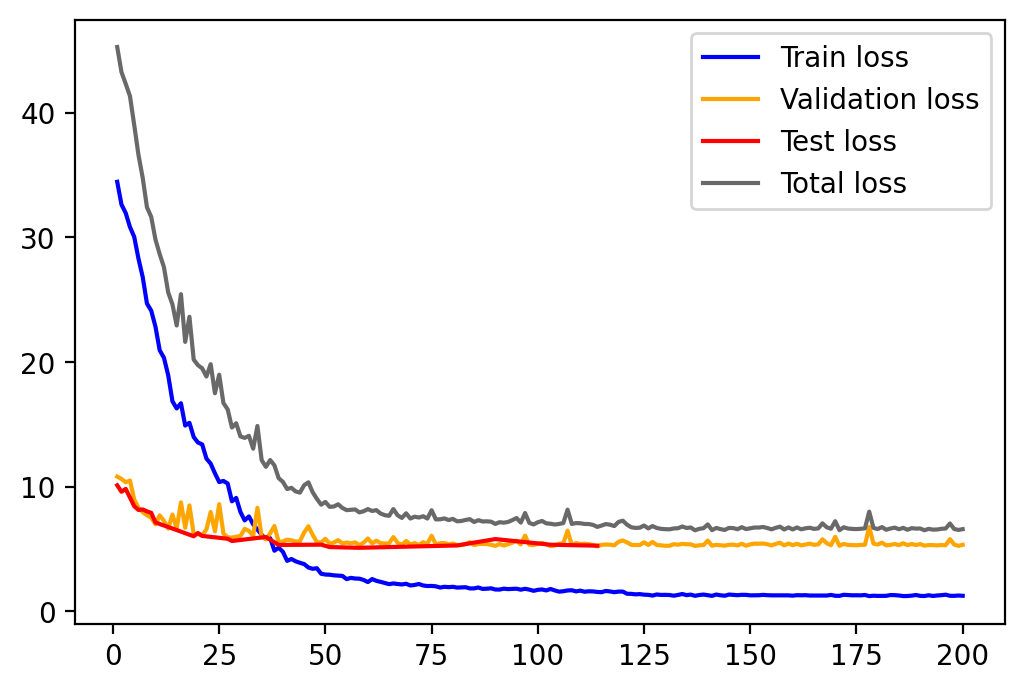

In [8]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [9]:
tsloss = 0
model.load_state_dict(torch.load('pw_statedict.pt'))
model.eval()
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


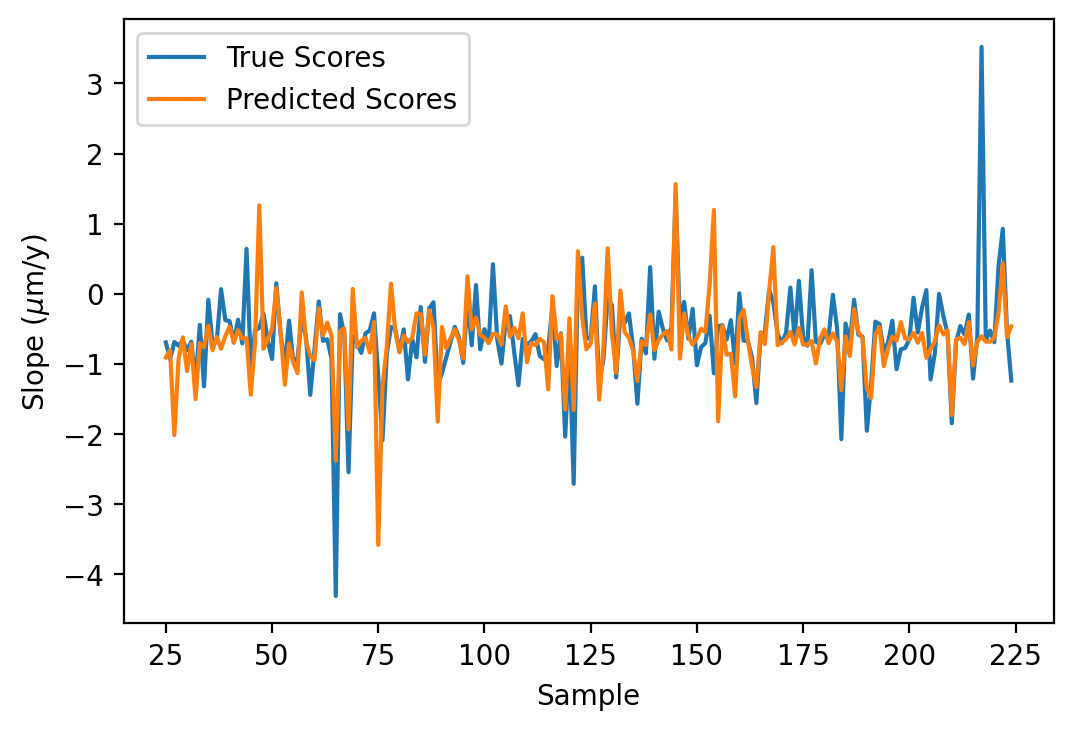

In [10]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

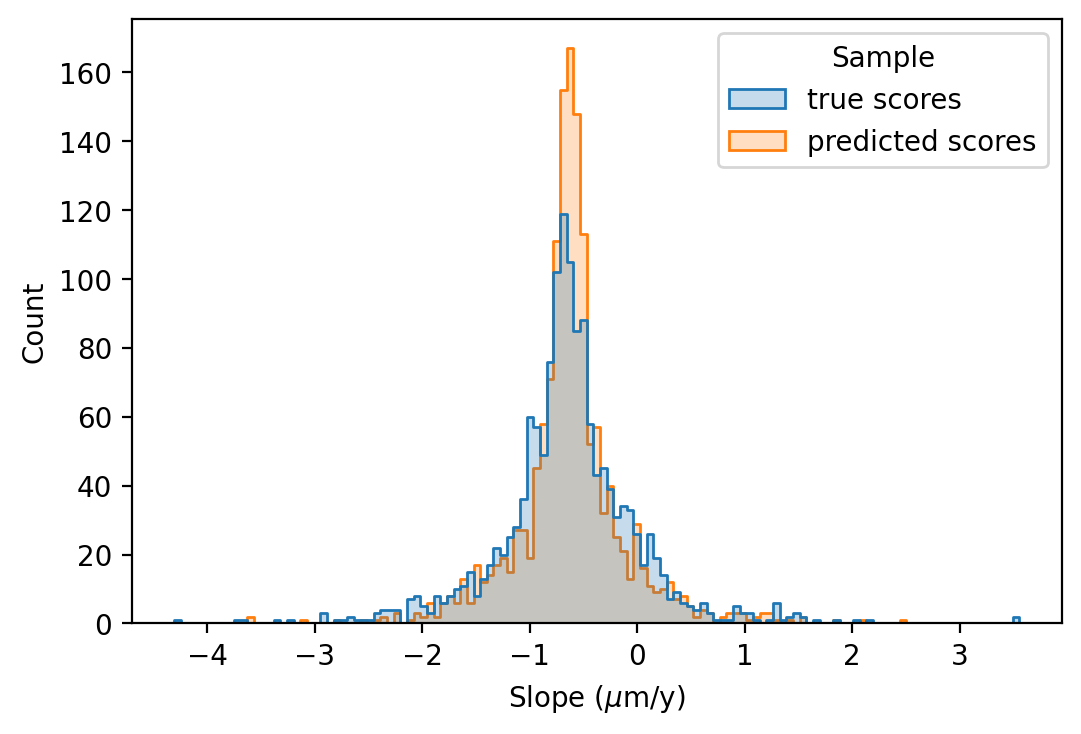

In [11]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [12]:
import pandas as pd
import numpy as np
df.to_csv('predscores.csv')
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)
print(coefficient_of_dermination)


0.49081991867527786


In [13]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [14]:
rsquared(true, pred)

0.5003265249212525

In [15]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6419934751134212, pvalue=5.7935042184484204e-173)

In [16]:
scipy.stats.pearsonr(true, pred)

(0.7073376314895544, 3.123746320713059e-225)